In general we are trying to solve an overdetermined system of equations, $\text{A}\bf{x} = \bf{b}$.

 - Each row in the matrix $\text{A}$ is derived from ratios of redundant visiblities, such that the elements of $\text{A}$ are integers representing the antennas used in that ratio

 - the vector $\bf{b}$ contains the sum of the antenna cable delays for that visibility ratio

 - the solution $\bf{x}$ will provide the cable delay $\tau$ for each antenna

\begin{equation}
\begin{bmatrix} 
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots& \cdots\\ 
1 & -1 & -1 & 1 & 0 & 0 & 0 & \cdots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots& \ddots\\ 
\end{bmatrix}
\begin{bmatrix} 
\tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \\ \tau_5 \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} =
\begin{bmatrix} 
134\text{ns} \\ 78\text{ns} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} \rightarrow \text{A}\bf{x} = \bf{b}
\end{equation}

Each visibility ratio is proportional to a complex exponential
\begin{equation}
\frac{V_{i j}}{V_{k l}} \propto \exp{\bigg(-2\pi i \cdot(\tau_i - \tau_j - \tau_k + \tau_l)\bigg)}
\end{equation}

Where in the example the first and second rows of $\text{A}$ are made from these visibilities:
\begin{align}
\frac{V_{12}}{V_{23}} &\leadsto 1\tau_1 -2\tau_2  + 1\tau_3 \rightarrow A_1\\
\frac{V_{12}}{V_{34}} &\leadsto 1\tau_1 -1\tau_2  - 1\tau_3 + 1\tau_4 \rightarrow A_2\\
\end{align} 

***


In [1]:
import random
import numpy as np

import estdel

from estdel_nn.data_creation import data_manipulation as dm

Load (or generate) a list of redundant baselines and get their data

In [2]:
red_bls, gains, uvd = dm.load_relevant_data('zen_data/zen.2458098.58037.xx.HH.uv',
                                            'zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [3]:
_, _bl_dict = dm.get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys(),
                                                     training_load_path = 'data/training_redundant_baselines_dict_80.npz',
                                                     testing_load_path = 'data/testing_redundant_baselines_dict_80.npz')
_bl_data = dm.get_seps_data(_bl_dict, uvd)

In [4]:
_bl_data = _bl_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [5]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

***

Get the unique antennas

In [43]:
unique_ants = []
for key in _bl_dict.keys():
    if len(_bl_dict[key]) >= 2:
        for sep in _bl_dict[key]:
            for ant in sep:
                if ant not in unique_ants:
                    unique_ants.append(ant)

In [44]:
unique_ants = sorted(unique_ants)

Assign each antenna a random delay in the range of -100ns to 100ns

In [45]:
generated_ant_delays = {ant : np.random.uniform(low = -0.0100, high = 0.0100) for ant in unique_ants}

Generate a list of abstracted visibility ratios from redundant baselines ( pairs of redundant separations)

In [46]:
num_V_ratios = 100
list_o_sep_pairs = []

for i in range(num_V_ratios):
    
    # Randomly select a redundant baseline
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    
    while len(_bl_dict[unique_baseline]) < 2:
        unique_baseline = random.sample(_bl_dict.keys(), 1)[0]

    # randomly select two sepearations from that baseline
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    
    list_o_sep_pairs.append(two_seps)

***
Construct Data

In [47]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [48]:
def get_target(two_seps, d):
    
    ants = flatten_list_o_tuples(two_seps)
    
    ratio_delay  = d[ants[0]]
    ratio_delay -= d[ants[1]]
    ratio_delay -= d[ants[2]]
    ratio_delay += d[ants[3]]
    
    return ratio_delay

In [49]:
inputs = []
targets = []
flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))

nu = np.arange(1024)
for i in range(num_V_ratios):
    

    two_seps = list_o_sep_pairs[i]       
    true_delay = get_target(two_seps, generated_ant_delays)
    v_ratio = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    inputs.append(v_ratio)
 

In [50]:
freqs = np.linspace(0.100,0.200,1024)

In [51]:
channel_width_in_GHz = np.mean(np.diff(freqs))

In [52]:
def scale_delays_to_ns(delays, channel_width_in_GHz = np.mean(np.diff(np.linspace(0.100,0.200,1024)))):
    return delays / channel_width_in_GHz

In [53]:
# delays in nanoseconds
true_ant_delays = {ant :scale_delays_to_ns(generated_ant_delays[ant]) for ant in generated_ant_delays.keys()}

In [54]:
np.unique(list_o_sep_pairs)

array([  1,  11,  12,  13,  14,  23,  24,  25,  26,  27,  36,  37,  38,
        39,  40,  41,  51,  52,  53,  54,  55,  65,  66,  67,  68,  69,
        70,  71,  82,  83,  84,  86,  87,  88, 120, 121, 122, 123, 124,
       137, 138, 139, 140, 141, 142, 143], dtype=int32)

In [55]:
tester = estdel.DelaySolver(list_o_sep_pairs, inputs, conversion_fn='default')

In [56]:
true_b = tester.true_b(true_ant_delays)

In [57]:
tester.predict()

In [58]:
pred_b = tester.v_ratio_row_predictions

In [59]:
# http://maxwell.ucsc.edu/~drip/133/ch4.pdf
red_chi2 = np.sum((pred_b - np.mean(pred_b))**2/np.std(pred_b)**2) / len(pred_b)

In [60]:
red_chi2

1.0000000000000002

In [61]:
import matplotlib.pyplot as plt

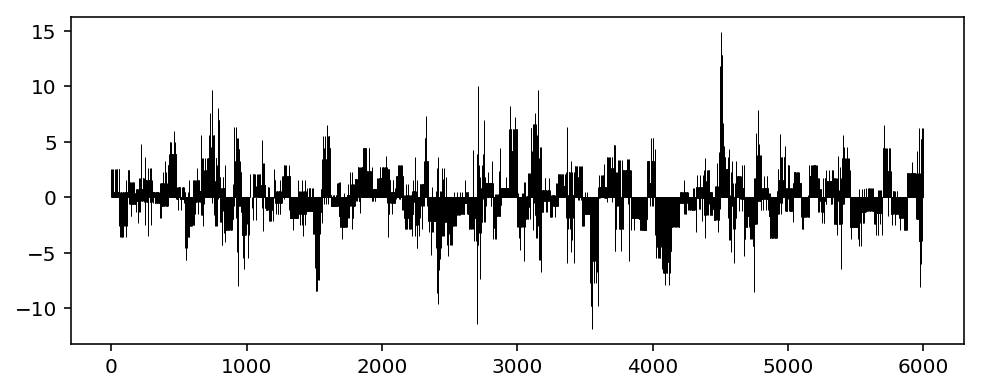

In [62]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.vlines(range(len(pred_b)), 0, true_b- pred_b, lw = 0.5);


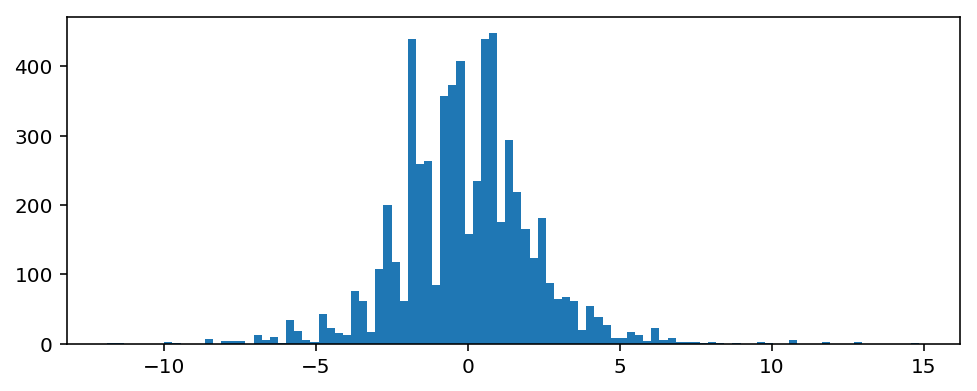

In [63]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.hist(true_b- pred_b, bins = 100);

In [66]:
np.std(np.abs(true_b- pred_b))

1.4690603307472008

In [67]:
A = tester.A

In [68]:
x_prediction_eval = np.linalg.lstsq(A[:, tester.unique_ants], pred_b, rcond = None)

In [69]:
x_prediction = x_prediction_eval[0]

In [70]:
x_prediction

array([ 14.38270112, -71.25807254,  31.12768763,  95.31048981,
       -46.58979282,  18.69873428,  52.46379305,  77.57537089,
       -43.83331429,  52.11009352, -19.2404874 , -87.27883836,
       -93.48388658,  -1.53840049,  18.53639411,   9.59412218,
       -78.50999148,  67.26008892, -42.58809851, -99.34283369,
        21.36082866,  37.50409003, -91.08343776,  20.29607327,
         8.94551611,  54.62687147,  43.18902185, -31.69637798,
       -11.73120839,  75.16301469,  18.73778883, -83.39196014,
        95.08247223,   4.3110653 , -96.13464276,  47.64984091,
        28.65923923, -46.23159984,   6.71367781,  92.032246  ,
        11.22701081,  32.10904739, -20.61206267, -57.2656438 ,
        13.41907676, -26.27570737])

In [71]:
predicted_antenna_delays = {tester.unique_ants[i]: x_prediction[i] for i in range(len(x_prediction))}
predicted_antenna_delays

{1: 14.382701123952597,
 11: -71.25807254088298,
 12: 31.12768762583415,
 13: 95.31048980605924,
 14: -46.58979281672049,
 23: 18.698734280905985,
 24: 52.463793051335294,
 25: 77.57537089478134,
 26: -43.833314294962506,
 27: 52.1100935208543,
 36: -19.240487401329545,
 37: -87.27883836031478,
 38: -93.48388657992325,
 39: -1.5384004893576488,
 40: 18.53639410598512,
 41: 9.594122177574068,
 51: -78.50999147514169,
 52: 67.26008892477618,
 53: -42.58809850632368,
 54: -99.34283369337358,
 55: 21.360828655273295,
 65: 37.50409003406292,
 66: -91.08343776074608,
 67: 20.29607327107252,
 68: 8.945516110253052,
 69: 54.62687147103776,
 70: 43.189021847599925,
 71: -31.696377977211732,
 82: -11.731208390869956,
 83: 75.16301469102723,
 84: 18.73778882552012,
 86: -83.39196013949984,
 87: 95.08247222893735,
 88: 4.311065298231798,
 120: -96.13464276259754,
 121: 47.649840913342004,
 122: 28.65923923009023,
 123: -46.23159983944444,
 124: 6.713677812150934,
 137: 92.0322459957595,
 138: 11.2

In [72]:
error = {}
error_ls = []
for key in sorted(predicted_antenna_delays.keys()):
    print('{:3d}: {:6.2f}, {:6.2f}'.format(key,predicted_antenna_delays[key], scale_delays_to_ns(generated_ant_delays[key])))
    error[key] = scale_delays_to_ns(generated_ant_delays[key]) - predicted_antenna_delays[key]
    error_ls.append(error[key])

  1:  14.38,  19.03
 11: -71.26, -74.10
 12:  31.13,  35.62
 13:  95.31, 101.63
 14: -46.59, -35.84
 23:  18.70,  12.10
 24:  52.46,  53.25
 25:  77.58,  82.07
 26: -43.83, -37.42
 27:  52.11,  68.02
 36: -19.24, -28.15
 37: -87.28, -93.33
 38: -93.48, -92.88
 39:  -1.54,   4.81
 40:  18.54,  29.97
 41:   9.59,  27.92
 51: -78.51, -83.93
 52:  67.26,  62.08
 53: -42.59, -38.65
 54: -99.34, -92.90
 55:  21.36,  34.35
 65:  37.50,  17.88
 66: -91.08, -101.87
 67:  20.30,  14.94
 68:   8.95,   7.31
 69:  54.63,  54.77
 70:  43.19,  47.53
 71: -31.70, -19.99
 82: -11.73, -25.83
 83:  75.16,  65.28
 84:  18.74,  12.28
 86: -83.39, -77.83
 87:  95.08, 102.12
 88:   4.31,  18.56
120: -96.13, -100.47
121:  47.65,  45.32
122:  28.66,  34.18
123: -46.23, -38.00
124:   6.71,  19.16
137:  92.03,  73.11
138:  11.23,  -4.15
139:  32.11,  23.15
140: -20.61, -26.77
141: -57.27, -55.63
142:  13.42,  17.53
143: -26.28, -17.66


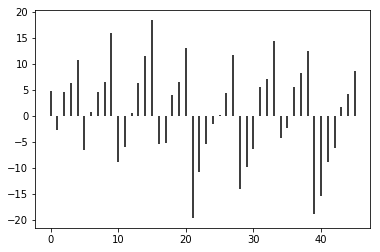

In [73]:
plt.vlines(range(len(error_ls)), 0, error_ls)